# Deploy Kimi k2.5 model on SageMaker AI

In this notebook we deploy Kimi K2.5 model on SageMaker AI.

Please see the Kimi2.5 Research Paper [blog](https://www.kimi.com/blog/kimi-k2-5.html) for more details

## Step 1: Setup

Fetch and import dependencies

In [3]:
%pip install sagemaker==2.245.0 --upgrade --quiet --no-warn-conflicts

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import json
import sagemaker
import boto3

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts
region = sess._region_name  # region name of the current SageMaker Studio environment
account_id = sess.account_id()

sm_client = boto3.client("sagemaker")  # client to intreract with SageMaker
smr_client = boto3.client("sagemaker-runtime")  # client to intreract with SageMaker Endpoints

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")
print(f"sagemaker version: {sagemaker.__version__}")

## Deployment

In [2]:
CONTAINER_VERSION = "0.36.0-lmi20.0.0-cu128-v1.0"
inference_image = f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:{CONTAINER_VERSION}"
#djl-inference:0.36.0-lmi20.0.0-cu128-v1.0
instance = {"type": "ml.p5e.48xlarge", "num_gpu": 8}

model_id = "moonshotai/Kimi-K2.5"

model_name = sagemaker.utils.name_from_base("modelv2", short=True)
endpoint_name = model_name
endpoint_config_name = model_name
inference_component_name = f"ic-{model_name}"
timeout = 2600

common_env = {
    "HF_MODEL_ID": model_id,
}
lmi_env = {
    "SERVING_FAIL_FAST": "true",
    "OPTION_ASYNC_MODE": "true",
    "OPTION_ROLLING_BATCH": "disable",
    "OPTION_ENTRYPOINT": "djl_python.lmi_vllm.vllm_async_service",
    "OPTION_TENSOR_PARALLEL_DEGREE": json.dumps(instance["num_gpu"]),
    "OPTION_MAX_MODEL_LEN": "262000",
    "OPTION_TRUST_REMOTE_CODE": "true",
    "OPTION_ENABLE_AUTO_TOOL_CHOICE": "true",
    "OPTION_TOOL_CALL_PARSER": "kimi_k2",
}
env = common_env | lmi_env

In [ ]:
from sagemaker.compute_resource_requirements.resource_requirements import ResourceRequirements

lmi_model = sagemaker.Model(
    image_uri=inference_image,
    env=env,
    role=role,
    name=model_name,
)

lmi_model.deploy(
    initial_instance_count=1,
    instance_type=instance["type"],
    container_startup_health_check_timeout=timeout,
    endpoint_name=endpoint_name,
    endpoint_type=sagemaker.enums.EndpointType.INFERENCE_COMPONENT_BASED,
    inference_component_name=inference_component_name,
    resources=ResourceRequirements(requests={"num_accelerators": instance["num_gpu"], "memory": 1024*10, "copies": 1,}),
)

llm = sagemaker.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sess,
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer(),
    component_name=inference_component_name
)

## Inference Examples

In [17]:
payload={
    "messages": [
        {"role": "user", "content": "what model are you?"}
    ],
}
res = llm.predict(payload)
print("-----\n" + res["choices"][0]["message"]["content"] + "\n-----\n")
print(res["usage"])

-----
 The user is asking "what model are you?" which is a straightforward question about my identity as an AI assistant. 

I should answer truthfully and accurately. I am Kimi, an AI assistant made by Moonshot AI. Specifically, I am Kimi K2.5 (based on my current configuration and capabilities).

Key points to include:
- Identify myself as Kimi
- Mention Moonshot AI as the company that created me
- Be helpful and direct
- Keep it concise but accurate

I should avoid:
- Pretending to be a different model (like GPT-4, Gemini, etc.)
- Being evasive about my identity
- Providing incorrect version information if I'm uncertain, though I can say I'm part of the K2.5 series or similar without being overly specific if that's appropriate.

Actually, looking at my current state, I am Kimi K2.5. I should state this clearly.

Structure of response:
1. Direct answer: I am Kimi, an AI assistant
2. Made by Moonshot AI
3. Specific model version: K2.5
4. Maybe a brief friendly acknowledgment

Let me ch

In [31]:
import json
import base64
import os

tools = [
    {
        "type": "function",
        "function": {
            "name": "read_image",
            "description": "Read and analyze an image file",
            "parameters": {
                "type": "object",
                "properties": {
                    "image_path": {"type": "string", "description": "Path to the image file"}
                },
                "required": ["image_path"],
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "write_csv",
            "description": "Write data to a CSV file",
            "parameters": {
                "type": "object",
                "properties": {
                    "file_path": {"type": "string", "description": "Path for the CSV file"},
                    "content": {"type": "string", "description": "CSV content as string"}
                },
                "required": ["file_path", "content"],
            },
        },
    },
]

def read_image(image_path: str):
    print(f'READ IMG TOOL: Reading image {image_path}')
    if not os.path.exists(image_path):
        return f"Error: File not found at {image_path}"
    with open(image_path, "rb") as f:
        img_b64 = base64.b64encode(f.read()).decode()
    ext = image_path.split('.')[-1].lower()
    mime = {"jpg": "jpeg", "jpeg": "jpeg", "png": "png", "gif": "gif", "webp": "webp"}.get(ext, "jpeg")
    return {"type": "image_url", "image_url": {"url": f"data:image/{mime};base64,{img_b64}"}}

def write_csv(file_path: str, content: str):
    print(f'WRITE CSV TOOL: Writing CSV {file_path}')
    with open(file_path, "w") as f:
        f.write(content)
    return f"CSV written to {file_path}"

tool_functions = {"read_image": read_image, "write_csv": write_csv}

In [44]:
system_prompt = """You are a helpful assistant with access to tools.
When you need to perform an action, USE THE TOOLS - don't just describe what you would do.
Always complete the task by calling the appropriate tools. Do not stop until the task is fully done."""

messages = [{"role": "system", "content": system_prompt}]

def log(title, content=""):
    print(f"\n{'─'*50}")
    print(title)
    if content:
        print(f"{'─'*50}")
        print(content)
    print(f"{'─'*50}")

def chat(user_input):
    log("USER", user_input)
    messages.append({"role": "user", "content": user_input})

    turn = 0
    while True:
        turn += 1
        log(f"MODEL (turn {turn})...")

        res = llm.predict({"messages": messages, "tools": tools, "tool_choice": "auto","temperature": 0.1,"top_p": 0.8})
        msg = res["choices"][0]["message"]
        messages.append(msg)

        if not msg.get("tool_calls"):
            log("RESPONSE", msg["content"])
            return msg["content"]

        for tc in msg["tool_calls"]:
            fn = tc["function"]
            args = json.loads(fn["arguments"])
            log(f"TOOL: {fn['name']}", json.dumps(args, indent=2))

            result = tool_functions[fn["name"]](**args)

            if fn["name"] == "read_image" and isinstance(result, dict):
                log("IMAGE LOADED", args["image_path"])
                messages.append({"role": "user", "content": [{"type": "text", "text": "Here is the image:"}, result]})
            else:
                log("RESULT", str(result)[:500])
                messages.append({"role": "tool", "tool_call_id": tc["id"], "content": str(result)})

# Usage - model decides to use read_image tool
response = chat("Check the schedule at /home/ec2-user/SageMaker/schedule_table_small.jpg and create a CSV")


──────────────────────────────────────────────────
USER
──────────────────────────────────────────────────
Check the schedule at /home/ec2-user/SageMaker/schedule_table_small.jpg and create a CSV
──────────────────────────────────────────────────

──────────────────────────────────────────────────
MODEL (turn 1)...
──────────────────────────────────────────────────

──────────────────────────────────────────────────
TOOL: read_image
──────────────────────────────────────────────────
{
  "image_path": "/home/ec2-user/SageMaker/schedule_table_small.jpg"
}
──────────────────────────────────────────────────
READ IMG TOOL: Reading image /home/ec2-user/SageMaker/schedule_table_small.jpg

──────────────────────────────────────────────────
IMAGE LOADED
──────────────────────────────────────────────────
/home/ec2-user/SageMaker/schedule_table_small.jpg
──────────────────────────────────────────────────

──────────────────────────────────────────────────
MODEL (turn 2)...
──────────────────────

📷 Original Image:


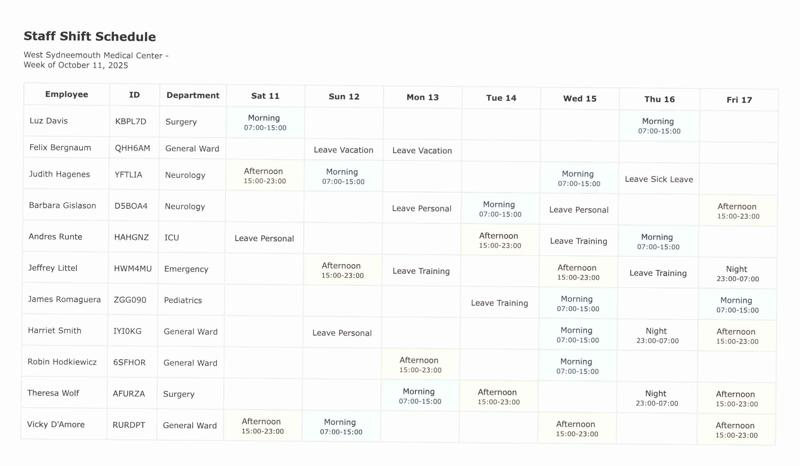


📊 Generated CSV:


,Employee,ID,Department,Sat 11,Sun 12,Mon 13,Tue 14,Wed 15,Thu 16,Fri 17
0,Luz Davis,KBPL7D,Surgery,Morning 07:00-15:00,NaN,NaN,NaN,NaN,Morning 07:00-15:00,NaN
1,Felix Bergnaum,QHH6AM,General Ward,NaN,Leave Vacation,Leave Vacation,NaN,NaN,NaN,NaN
2,Judith Hagenes,YFTLIA,Neurology,Afternoon 15:00-23:00,Morning 07:00-15:00,NaN,NaN,Morning 07:00-15:00,Leave Sick Leave,NaN
3,Barbara Gilason,DSBOA4,Neurology,NaN,NaN,Leave Personal,Morning 07:00-15:00,Leave Personal,NaN,Afternoon 15:00-23:00
4,Andres Runte,HAHGNZ,ICU,Leave Personal,NaN,NaN,Afternoon 15:00-23:00,Leave Training,Morning 07:00-15:00,NaN
5,Jeffrey Littel,HWM4MU,Emergency,NaN,Afternoon 15:00-23:00,Leave Training,NaN,Afternoon 15:00-23:00,Leave Training,Night 23:00-07:00
6,James Romaguera,ZGG090,Pediatrics,NaN,NaN,NaN,Leave Training,Morning 07:00-15:00,Morning 07:00-15:00,NaN
7,Harriet Smith,IYI0KG,General Ward,NaN,Leave Personal,NaN,NaN,Morning 07:00-15:00,Night 23:00-07:00,Afternoon 15:00-23:00
8,Robin Hoshiewicz,6SFHOR,General Ward,NaN,NaN,Afternoon 15:00-23:00,NaN,Morning 07:00-15:00,NaN,NaN
9,Therese Wolf,AFURZA,Surgery,NaN,NaN,Morning 07:00-15:00,Afternoon 15:00-23:00,NaN,Night 23:00-07:00,Afternoon 15:00-23:00


In [45]:
from IPython.display import display, Image
import pandas as pd

def show_results(image_path, csv_path):
    print("📷 Original Image:")
    display(Image(filename=image_path))
    print("\n📊 Generated CSV:")
    display(pd.read_csv(csv_path))

show_results("/home/ec2-user/SageMaker/schedule_table_small.jpg", "/home/ec2-user/SageMaker/schedule_table.csv")

## Cleanup

In [ ]:
sess.delete_inference_component(inference_component_name, wait=True)
sess.delete_endpoint(endpoint_name)
sess.delete_endpoint_config(endpoint_name)
sess.delete_model(model_name)